In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import seaborn
import matplotlib.pyplot as plt
import os
import emcee

In [3]:
import numpy as np
import pickle

cosmos_f = open('cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

box = 'Box0_1400'
h = cosmo_params[box]['H0']/100

Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_Pk.pkl'
Pk_f = open(Pk_fname, 'rb')
Pkz = pickle.load(Pk_f) #Pkz is a dictonary of functions
Pk_f.close()

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

In [4]:
#slight floating point error fix
#needed since I set the dictionary 
#equal to the redshift or scale
z_to_a = dict(zip(Pkz.keys(), NvMs.keys()))
a_to_z = dict(zip(NvMs.keys(), Pkz.keys()))

  0%|          | 0/16 [00:00<?, ?it/s]


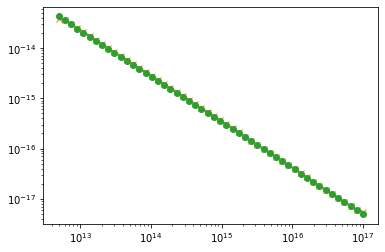

In [146]:
data = []

from utils import *

N_data = []
from scipy.interpolate import interp1d

dlnσinvdMs = {}

vol = -1
Mpart = -1

for z in tqdm(Pkz.keys()):
    a = z_to_a[z]
    
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M']
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])
    
    datapoint = {}
    for N_cur, M_cur, edge_pair in zip(N,Ms, edge_pairs ):
        datapoint['a'] = a
        datapoint['M'] = M_cur
        datapoint['edge_pairs'] = edge_pair   
        
        N_data += [N_cur]
        data += [datapoint]
    
    M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)
    
    
    R = [M_to_R(m, box, a) for m in M_numerics]
    
    sigma2s = [sigma2(Pk, r) for r in R]
    sigma = np.sqrt(sigma2s)
    lnsigmainv = -np.log(sigma)
    dlnsinvdM = np.gradient(lnsigmainv, M_numerics)

    dσ2dR = [dsigma2dR(Pk, r) for r in R]
    dRdMs = [dRdM(m_c, box, a) for m_c in M_numerics]
    dlnσinvdM_2 = -1/2 *np.array([a/b*c for (a,b,c) in zip(dσ2dR, sigma2s, dRdMs)])
    
    f_dlnsinvdM_log = interp1d(np.log10(M_numerics), dlnsinvdM,kind='cubic')
    f_dlnsinvdM = lambda x: f_dlnsinvdM_log(np.log10(x))

    dlnσinvdMs[a] = f_dlnsinvdM
    
    f_M = np.logspace(np.log10(np.min(Ms)), np.log10(np.max(Ms)-1),100)
    plt.plot(M_numerics, f_dlnsinvdM(M_numerics))
    plt.plot(M_numerics, dlnsinvdM, 'x')
    plt.plot(M_numerics, dlnσinvdM_2, 'o')

    plt.xscale('log')
    plt.yscale('log')
    break
N_data = np.array(N_data)

In [147]:
from massfunction import *

In [148]:
from scipy.stats import poisson
param_names = ['d0', 'd1',
               'e0', 'e1',
               'f0', 'f1',
               'g0', 'g1']
FIXED_VALS = {}

In [149]:
def log_prior(param_values):
    #uniform prior
    params = dict(zip(param_names, param_values))
    for param in FIXED_VALS:
        params[param] = FIXED_VALS[param]

    for c_data in data:
        curr_params = [p(c_data['a'], params['%s0'%l], params['%s1'%l]) for l in ['d','e','f','g']]
        for curr_param in curr_params:
            if(curr_param< 0 or curr_param>5):
                return -np.inf
    return 0

In [150]:
M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

In [166]:
def log_prob(param_values):   
    if(log_prior(param_values) == -np.inf):
        return -np.inf
    
    params = dict(zip(param_names, param_values))
    tinker_fs = {}
    
    for a in NvMs.keys():
        if(a != 0.25):
            continue
        tinker_eval = [tinker(a, M_c,**params, 
                              dlnσinvdM=dlnσinvdMs[a], 
                              Pk=Pkz[a_to_z[a]],
                              R=M_to_R(M_c, box, a),
                              rhobm=rhom_a(box,a))*vol for M_c in M_numerics]
        f_dndlogM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
        tinker_fs[a] = f_dndlogM
        
        
    model_vals = [ quad(tinker_fs[c_data['a']], 
                        (c_data['edge_pairs'][0]),  
                        (c_data['edge_pairs'][1]))[0]
                  for c_data in data]
    model_vals = np.array(model_vals)
    

    log_probs = poisson.logpmf(N_data, mu=model_vals)
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)

In [167]:
def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [171]:
guess = np.random.uniform(low=0, high=3, size=(len(param_names)))
guess[0] = 2.4
guess[5] = 0.12
while(not np.isfinite(log_likelihood(guess))):
    guess = np.random.uniform(low=0, high=3, size=(len(param_names)))
    guess[0] = 2.4
    guess[5] = 0.12


#Start by sampling with a maximum likelihood approach
from scipy import optimize as optimize
nll = lambda *args: -log_likelihood(*args)
result = optimize.minimize(nll, guess, method='BFGS')

/home/users/delon/.local/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/delon/.local/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [172]:
print(result)
MLE_params = dict(zip(param_names, result['x']))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 31704.538980293742
        x: [ 3.215e+00  2.062e+00  7.633e-01  9.498e-01  1.952e+00
             3.599e-01  4.384e-01  8.999e-01]
      nit: 8
      jac: [-8.130e-02  2.002e-02 -2.085e-01  5.249e-02 -1.538e-01
             3.613e-02  3.992e+00 -9.773e-01]
 hess_inv: [[ 7.815e-02  3.052e-01 ...  1.884e-01  7.537e-01]
            [ 3.052e-01  1.208e+00 ...  7.036e-01  2.814e+00]
            ...
            [ 1.884e-01  7.036e-01 ...  1.667e+00  6.668e+00]
            [ 7.537e-01  2.814e+00 ...  6.668e+00  2.667e+01]]
     nfev: 355
     njev: 37


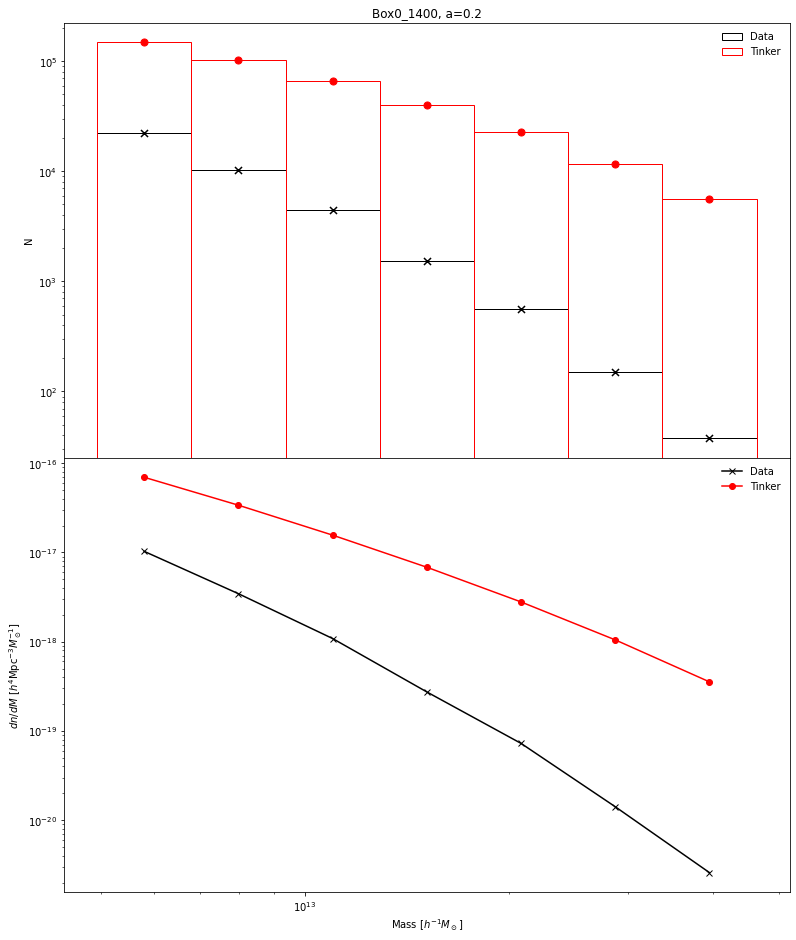

In [173]:
from scipy.interpolate import interp1d
i=0
for z in Pkz.keys():
    a = z_to_a[z]
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,16))
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M']
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    
    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]



    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])
    dndM = (N/vol)/dM

    tinker_eval = [tinker(a, M_c,**MLE_params,
                          dlnσinvdM=dlnσinvdMs[a], 
                          Pk=Pkz[z],
                          R=M_to_R(M_c, box, a),
                          rhobm=rhom_a(box,a)) for M_c in Ms]

    axs[1].plot(Ms, dndM, 'x-', color='black', label='Data')
    axs[1].plot(Ms, tinker_eval, 'o-', color='red', label='Tinker')



    tinker_eval = [tinker(a, M_c,**MLE_params,
                          dlnσinvdM=dlnσinvdMs[a], 
                          Pk=Pkz[z],
                          R=M_to_R(M_c, box, a),
                          rhobm=rhom_a(box,a))*vol for M_c in M_numerics]
    
    f_dndM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
    
    tinker_eval = np.array([quad(f_dndM, edge[0],  edge[1])[0] for edge in edge_pairs])

    color = plt.colormaps["rainbow"]((i+1)/len(Pkz.keys()))[:-1]

    
    edge_centers = [np.sqrt(edge[0]*edge[1]) for edge in edge_pairs]
    
    axs[0].scatter(Ms, N, s=50, marker='x', c='black')
    axs[0].scatter(edge_centers, tinker_eval, s=50 , marker='o', c='red')
    
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges), align='edge', fill=False, ec='black', label='Data')
    axs[0].bar(x=edges[:-1], height=tinker_eval, width=np.diff(edges), align='edge', fill=False, ec='red', label='Tinker')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].legend(frameon=False)
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$dn/dM\ [h^4{\rm Mpc}^{-3}M_\odot^{-1}]$')
    axs[0].set_title('%s, a=%.1f'%(box, a))
    i+=1
    plt.savefig('figures/%s_MLFits_a%.1f.pdf'%(box, a), bbox_inches='tight')
    plt.show()
    break

In [97]:
nwalkers = 32
ndim = len(param_names)

initialpos = np.array([result['x'] for _ in range(nwalkers)]) + 1e-4 * np.random.normal(size=(nwalkers, ndim))

In [98]:
print(initialpos)

[[1.41784005 0.2942787  0.06631519 2.19075828 1.06409175 2.22502509]
 [1.41769687 0.29430588 0.06650354 2.19077409 1.06409253 2.22499646]
 [1.41782842 0.2941992  0.06634074 2.190728   1.06422327 2.22498936]
 [1.41792398 0.29420624 0.06645349 2.19104271 1.06406715 2.22514021]
 [1.41763141 0.2943133  0.06639465 2.1909384  1.06417196 2.22499864]
 [1.41775984 0.29428207 0.06653073 2.19065912 1.06398087 2.2249927 ]
 [1.41782303 0.2943311  0.06643066 2.19107525 1.06394836 2.22519256]
 [1.41774381 0.29420008 0.0664825  2.19092795 1.06400512 2.2248941 ]
 [1.41772959 0.29420736 0.06632994 2.19079831 1.063952   2.22521729]
 [1.41773822 0.29416978 0.06637304 2.19089085 1.06402362 2.22493749]
 [1.41772033 0.29437565 0.06633485 2.19070138 1.06410536 2.22485168]
 [1.41763218 0.29427718 0.06658746 2.19090682 1.06408778 2.22509273]
 [1.41771441 0.29422739 0.06642853 2.19089358 1.06398669 2.2250951 ]
 [1.41786079 0.29448737 0.06660303 2.19077411 1.06395725 2.22512905]
 [1.41776474 0.29431515 0.06649703

In [99]:
from multiprocessing import Pool

sampler = emcee.EnsembleSampler(
    nwalkers = nwalkers,
    ndim = ndim,
    log_prob_fn = log_likelihood,
    pool=Pool()
)

sampler.run_mcmc(initialpos, 500, progress=True);

100%|██████████| 500/500 [40:55<00:00,  4.91s/it]


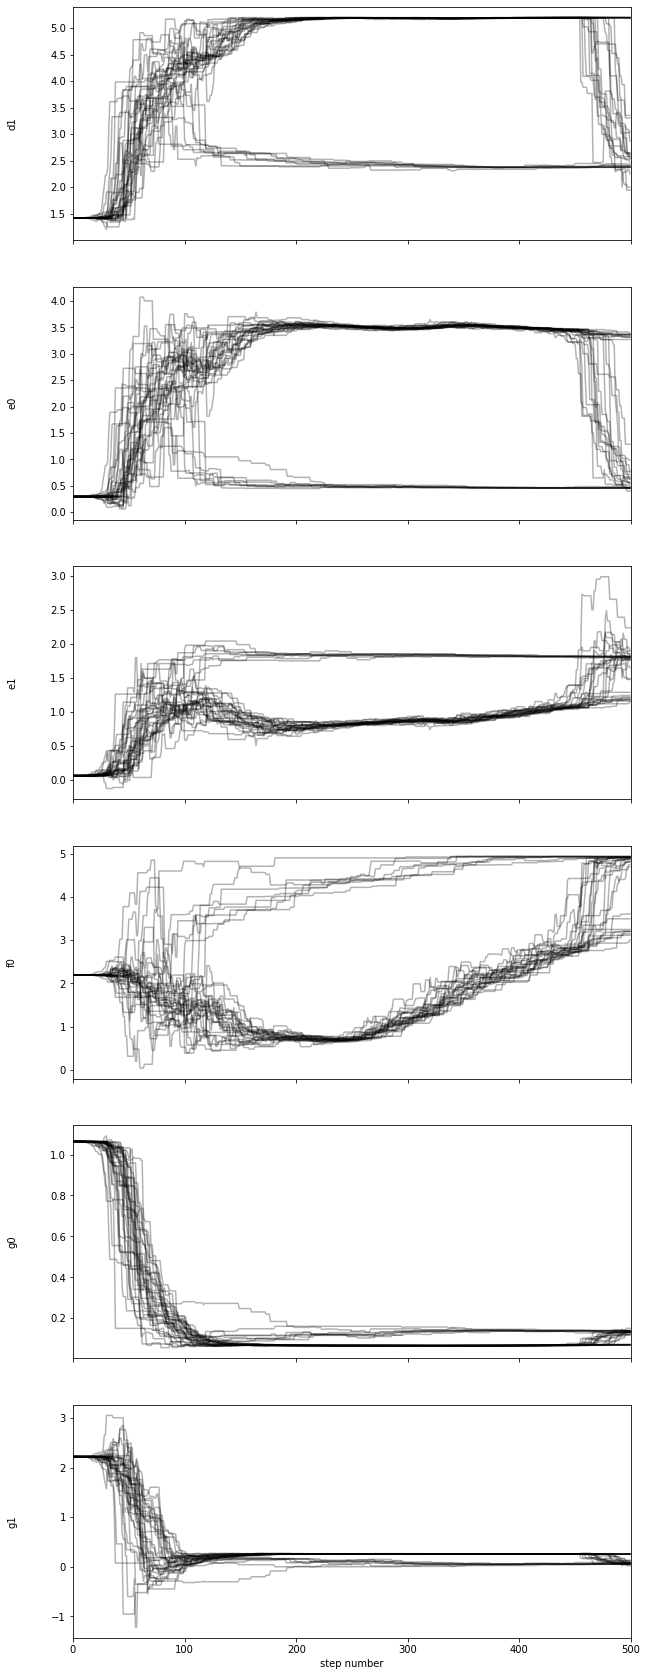

In [100]:
fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = sampler.get_chain()
labels = param_names

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

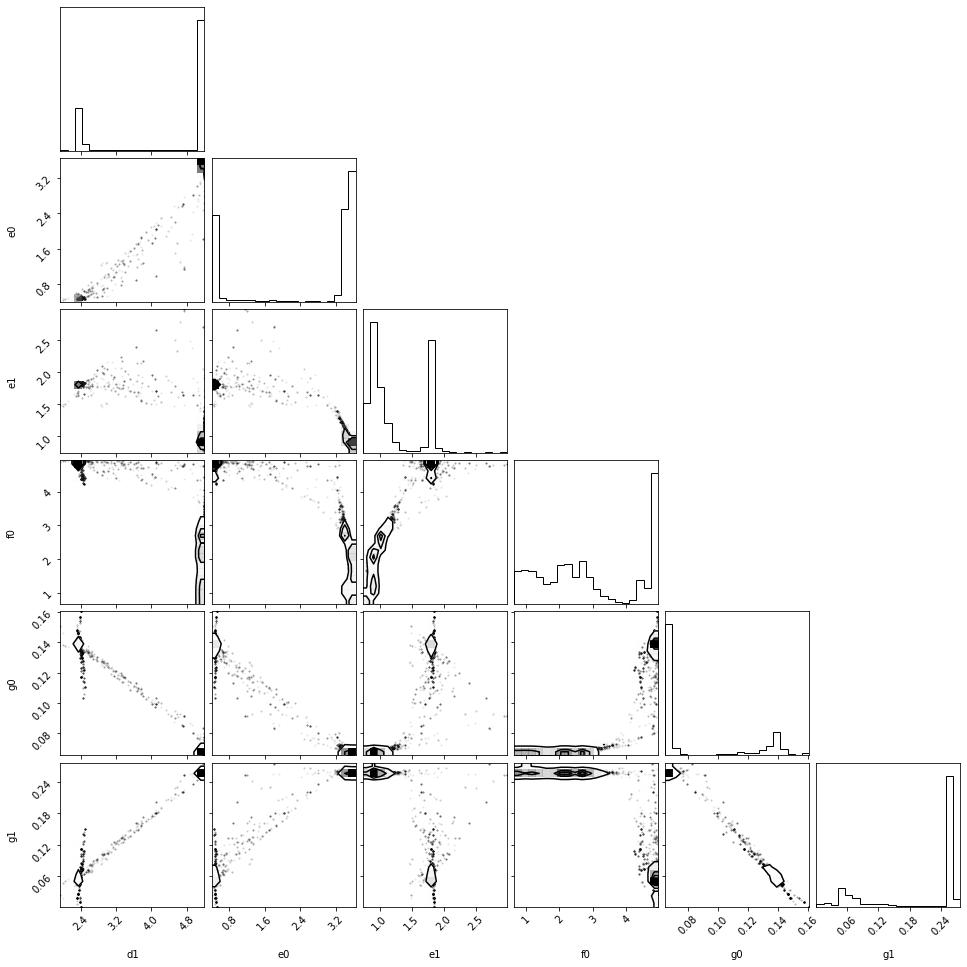

In [102]:
import corner
samples = sampler.chain[:, 250:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=labels)


In [103]:
params_final = dict(zip(param_names,np.percentile(samples,  50,axis=0)))

In [104]:
print(params_final)

{'d1': 5.189419885779537, 'e0': 3.4695564020249883, 'e1': 1.0257271187890151, 'f0': 2.5718738630209788, 'g0': 0.06711758201481066, 'g1': 0.25770318631803113}


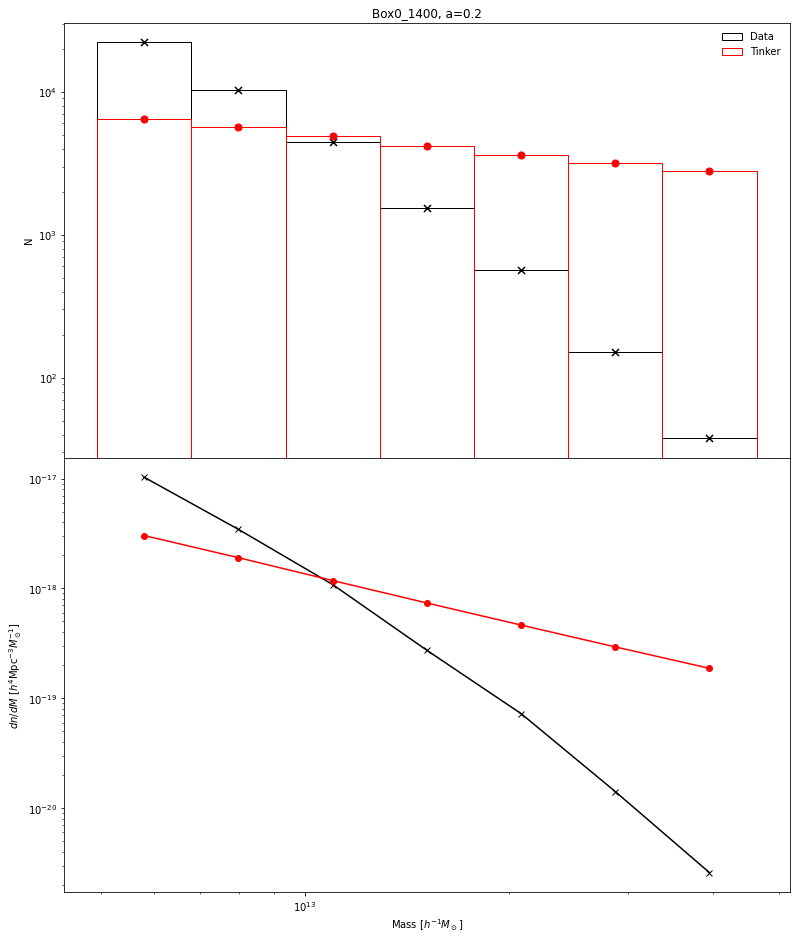

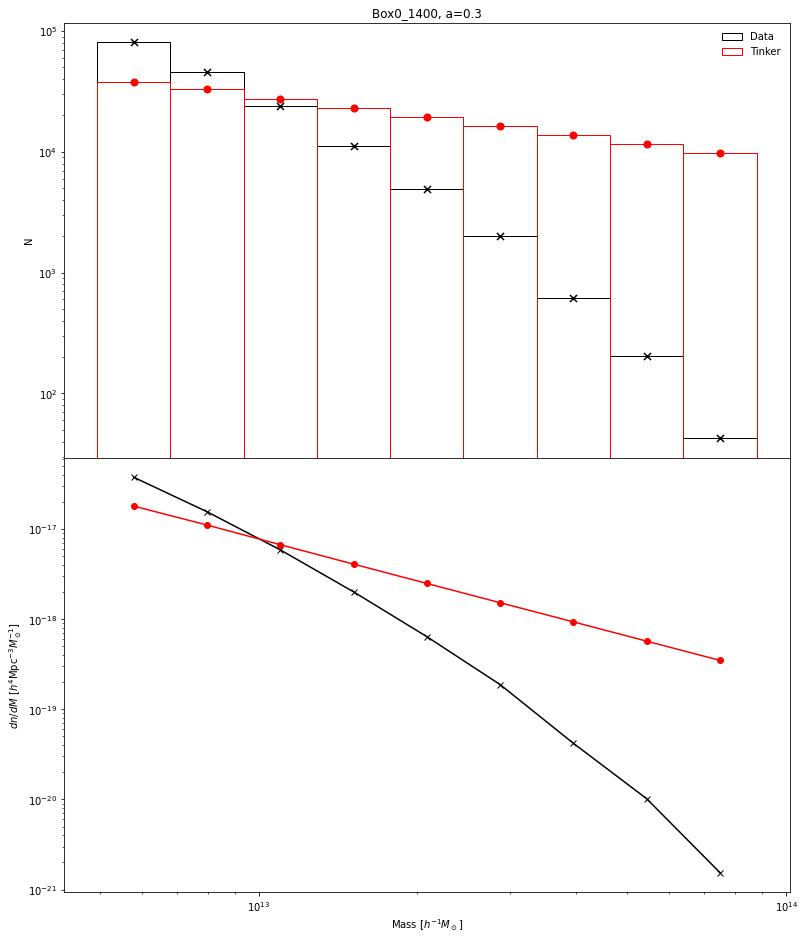

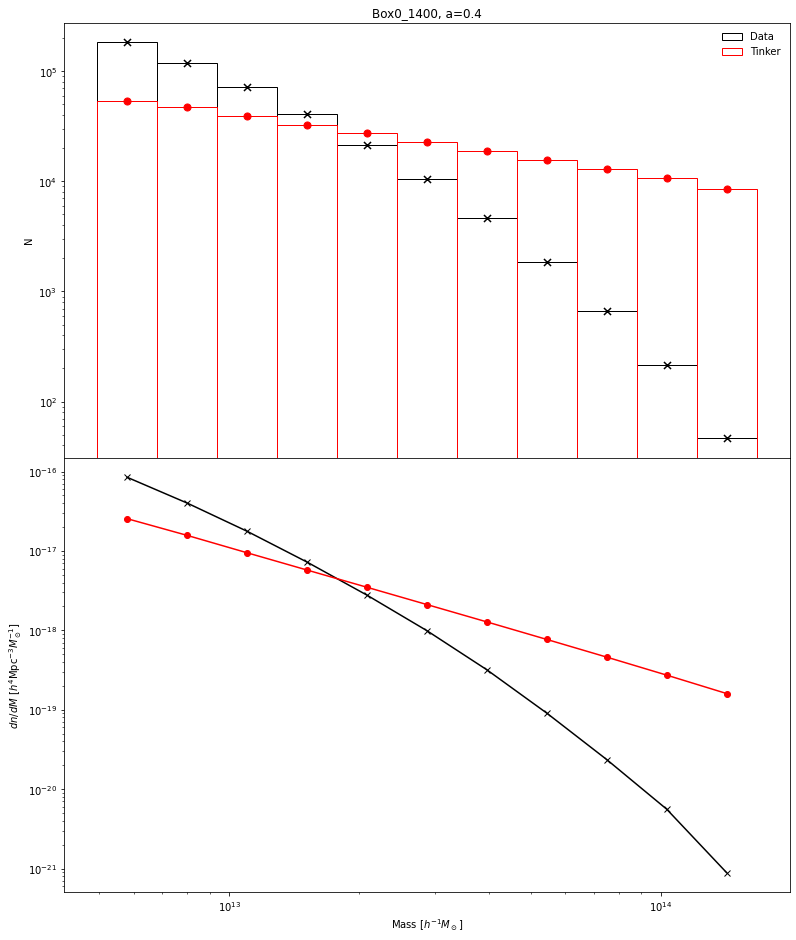

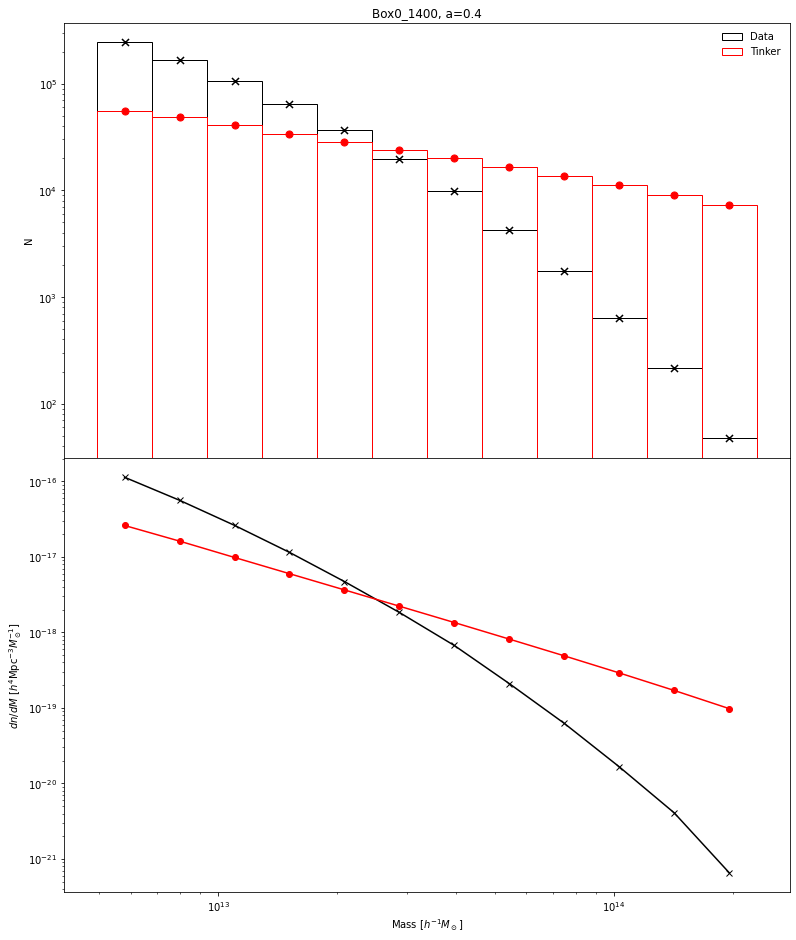

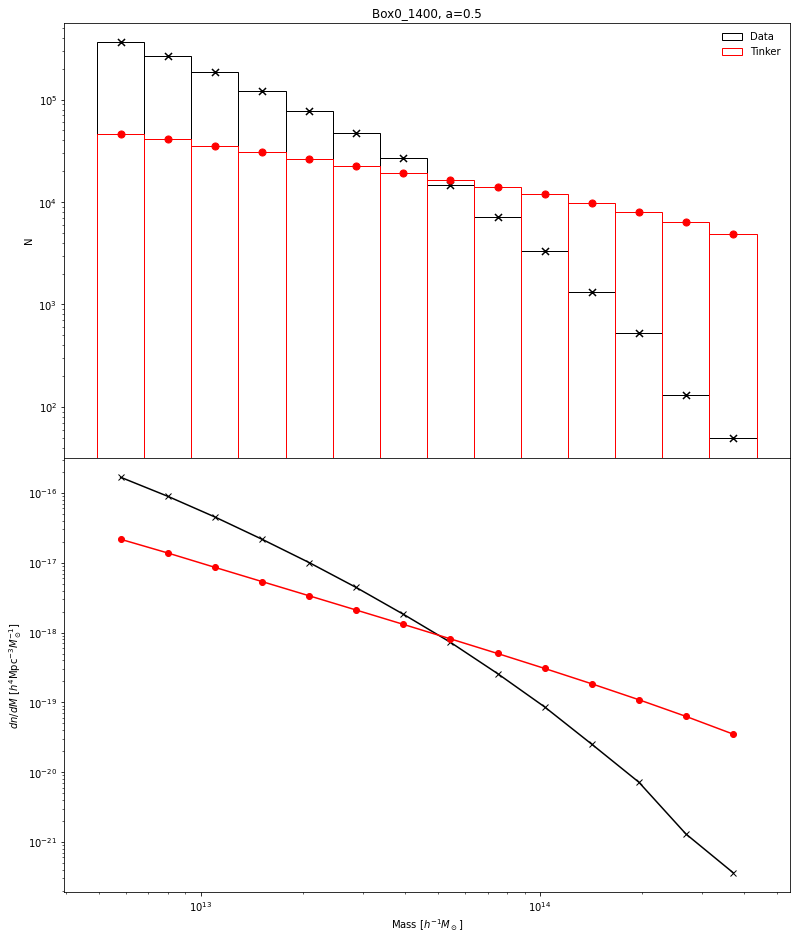

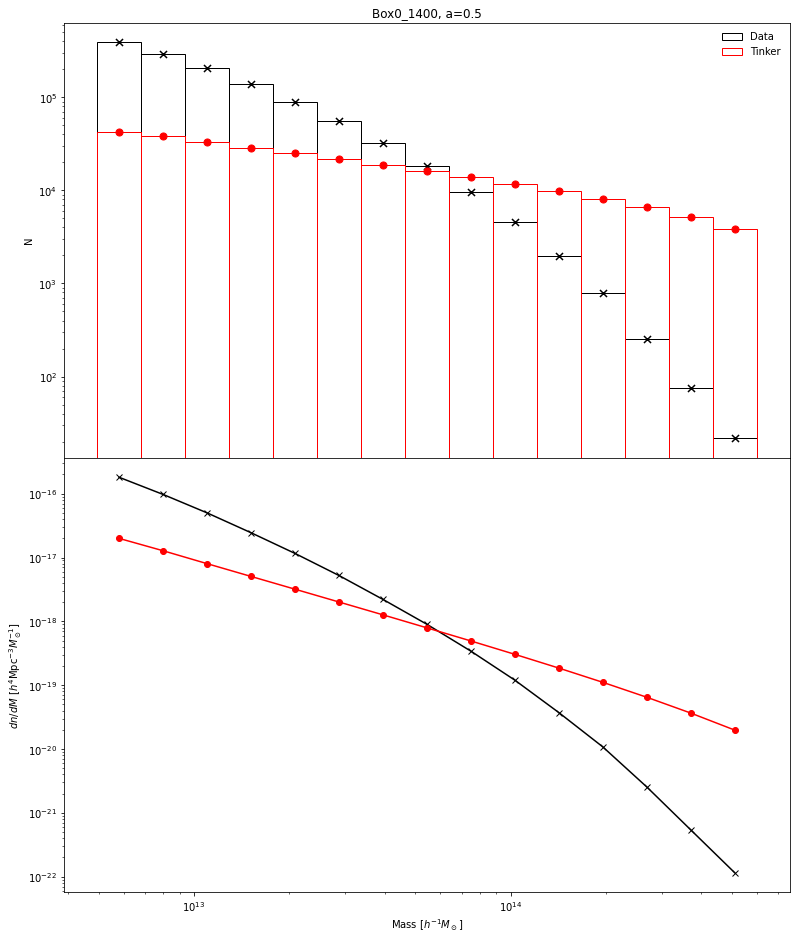

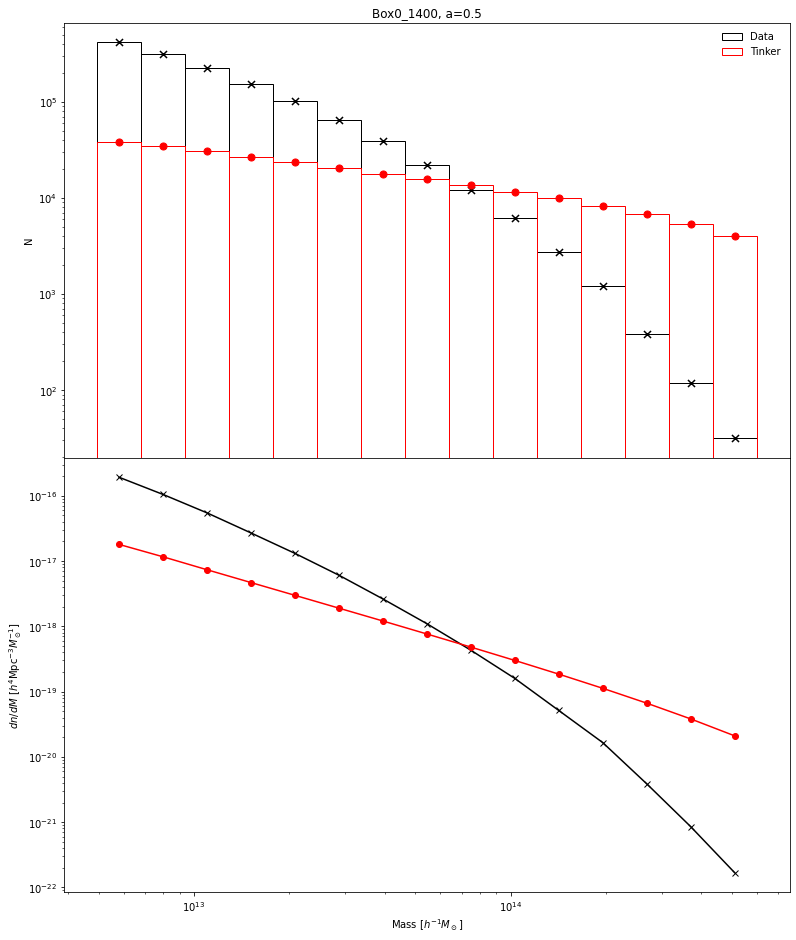

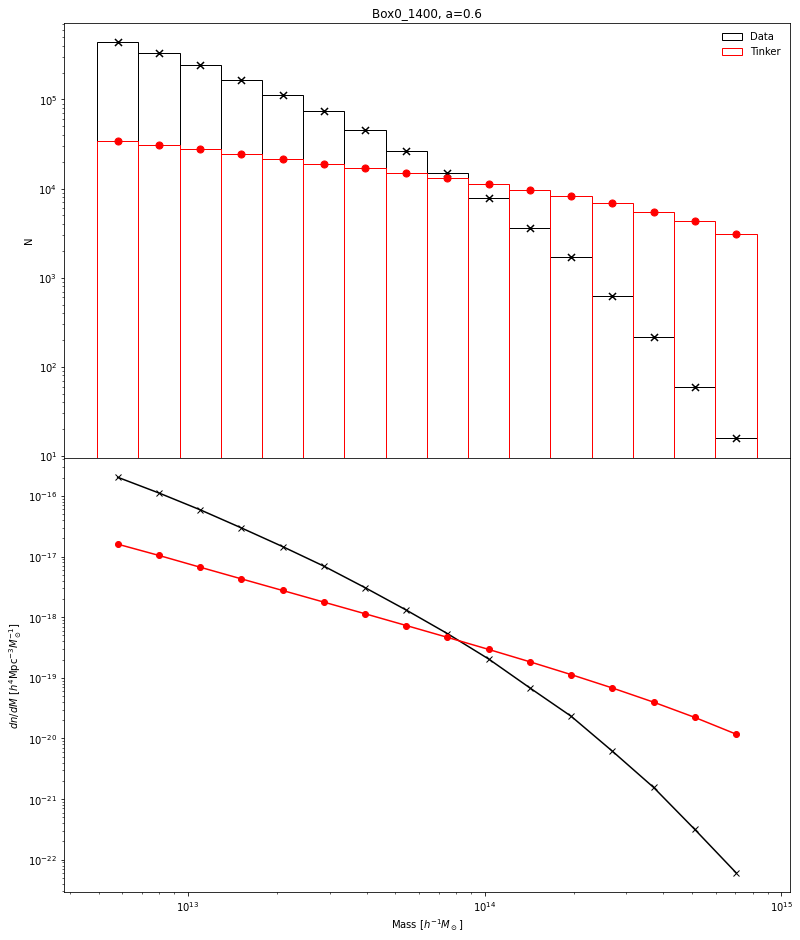

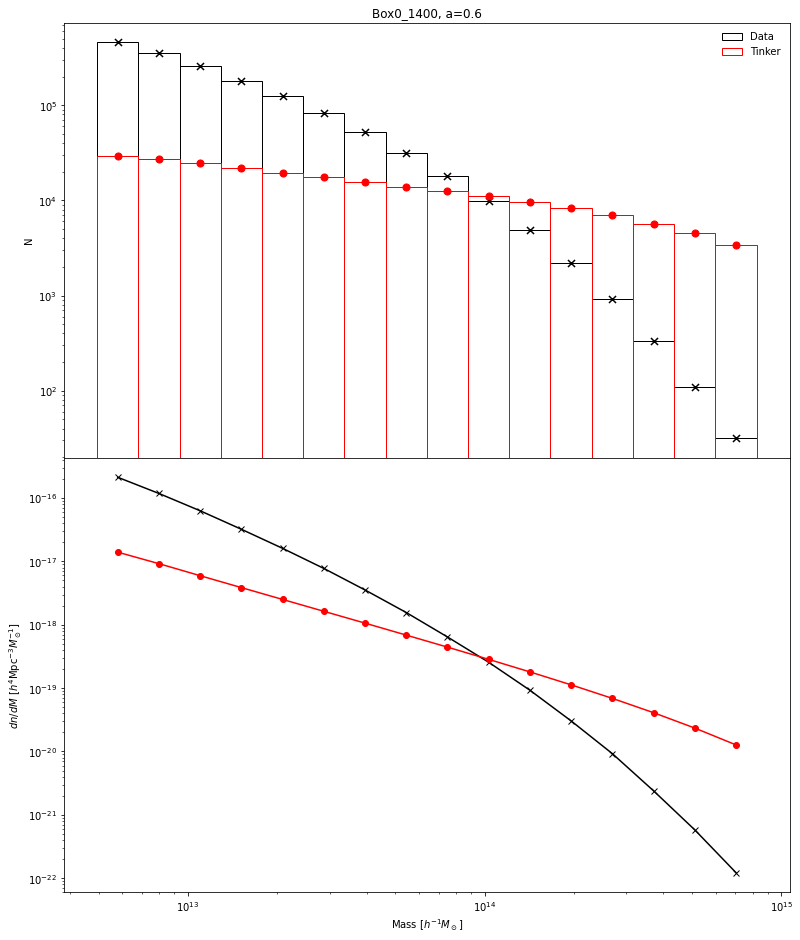

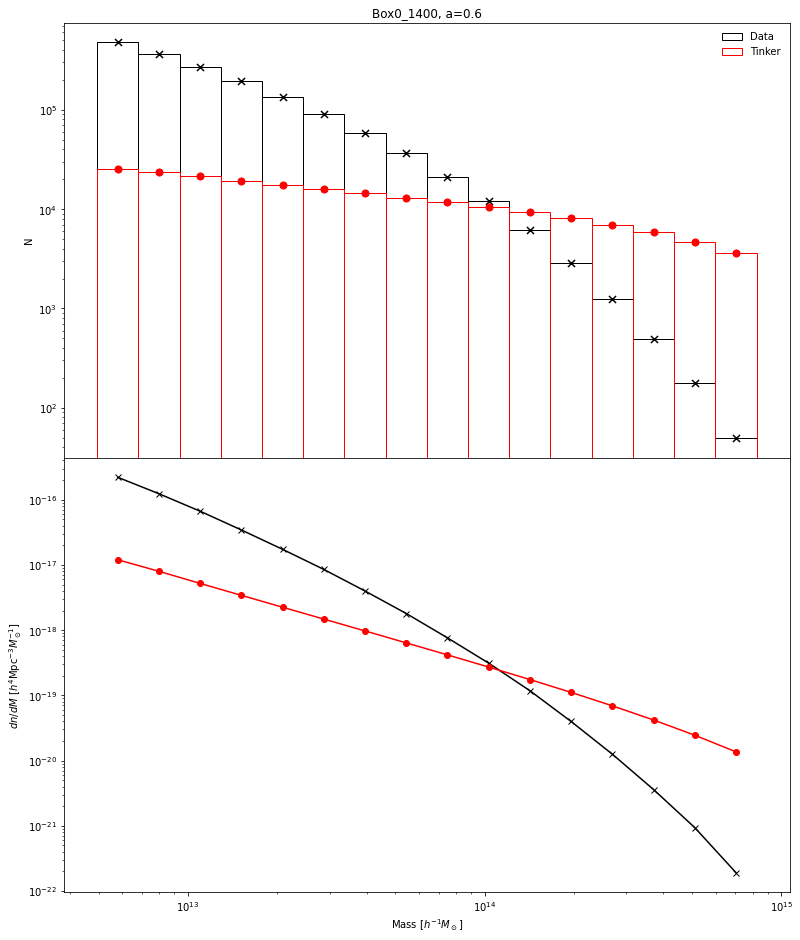

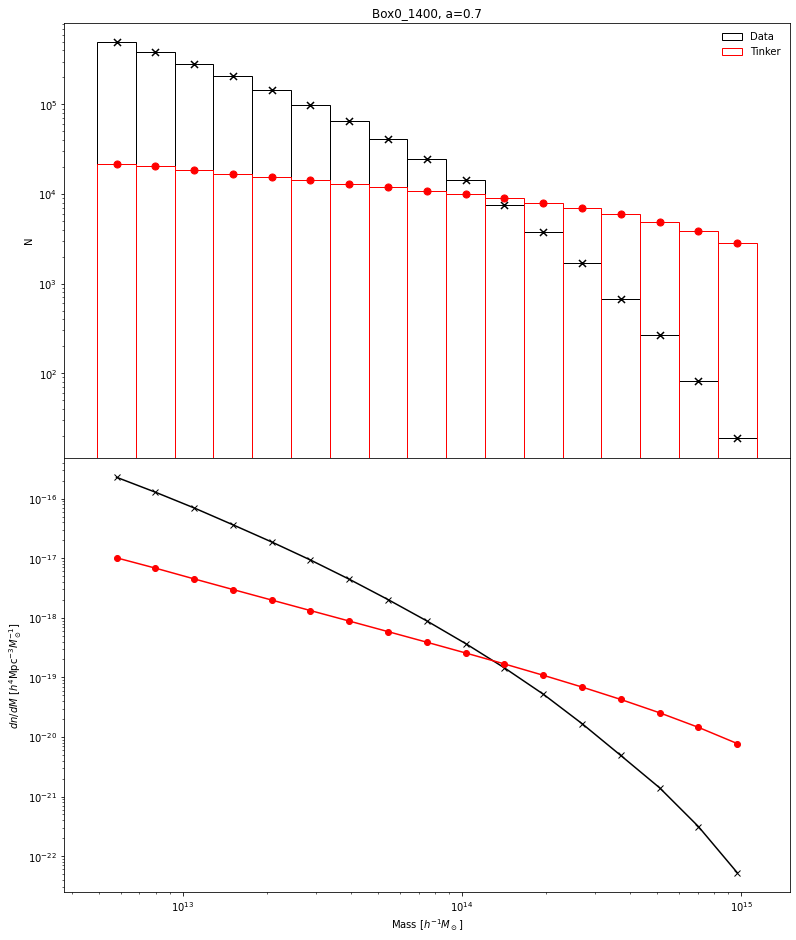

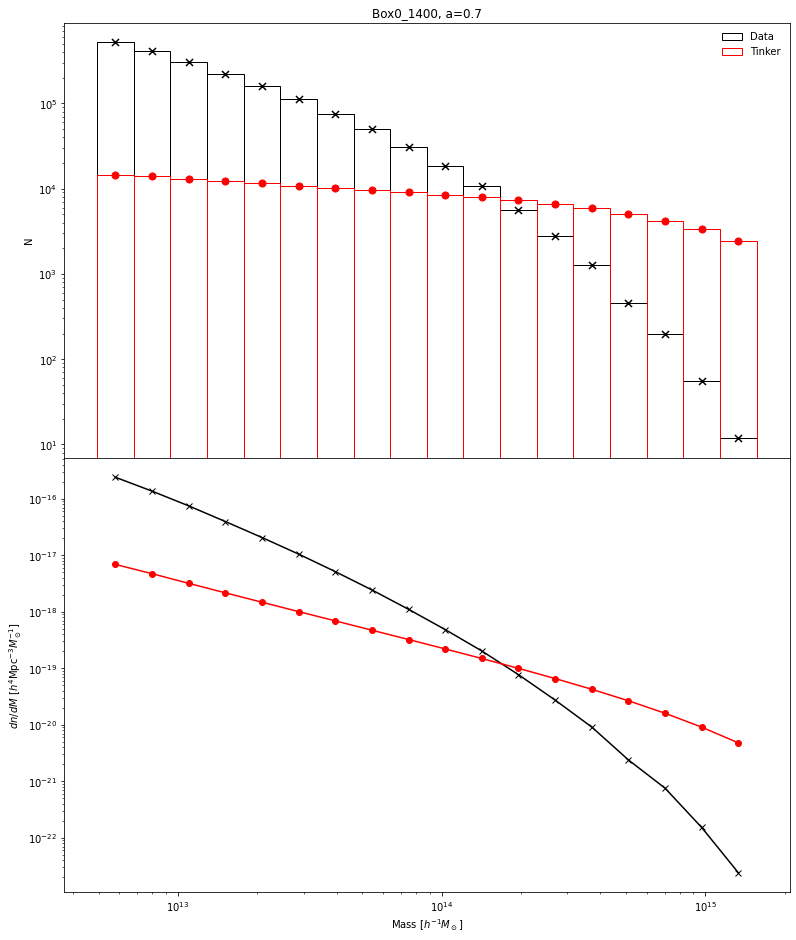

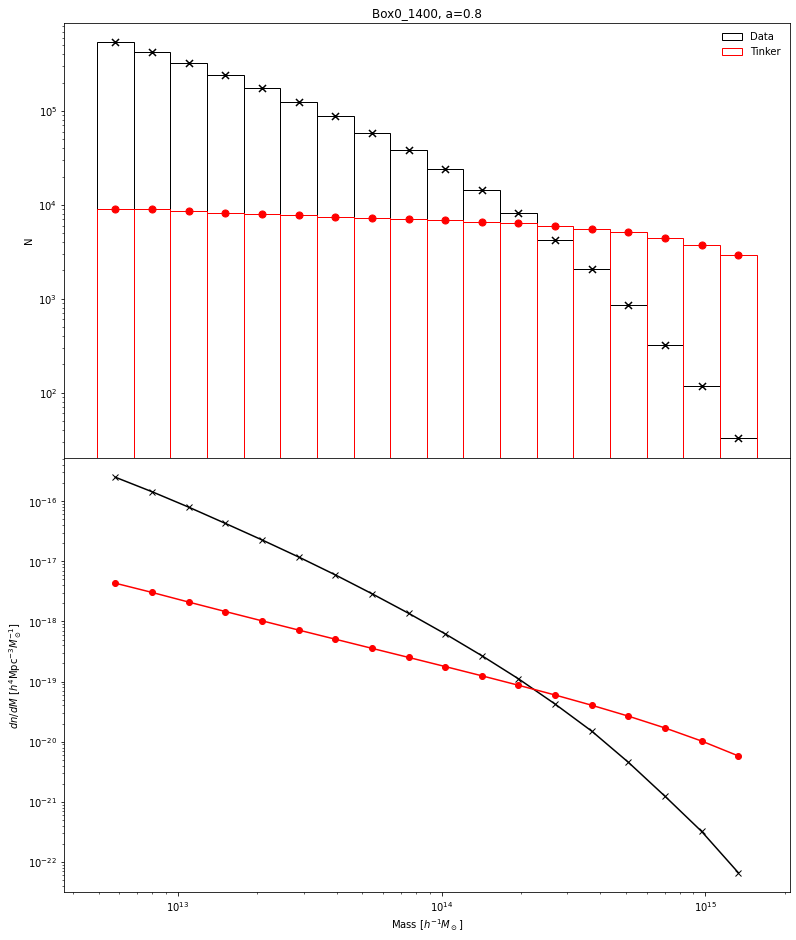

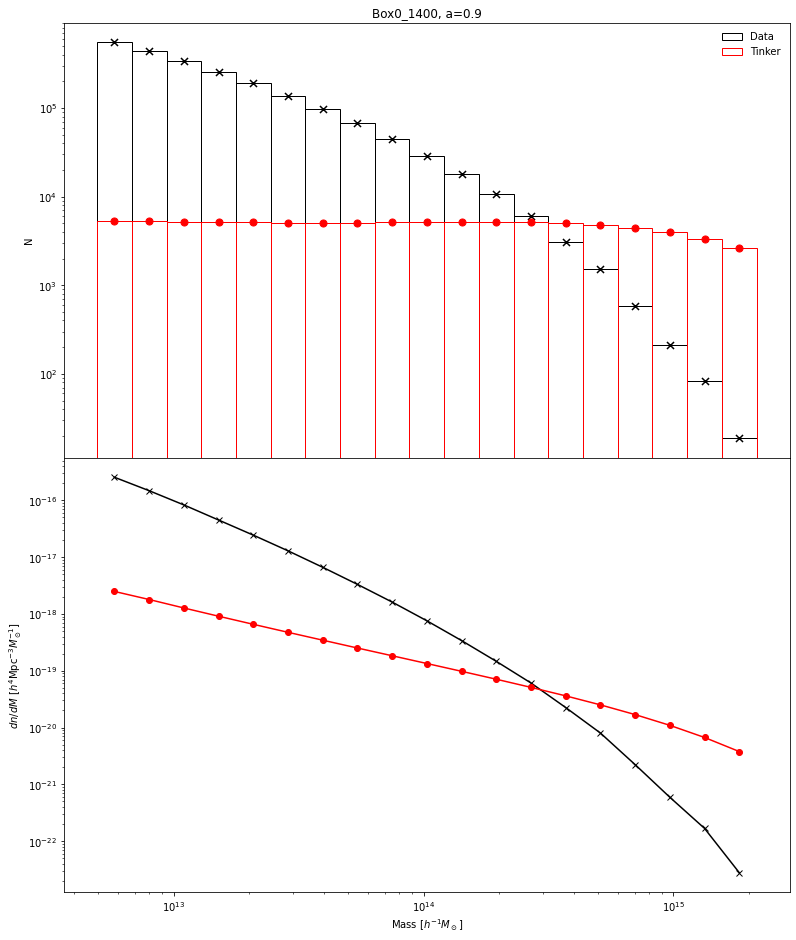

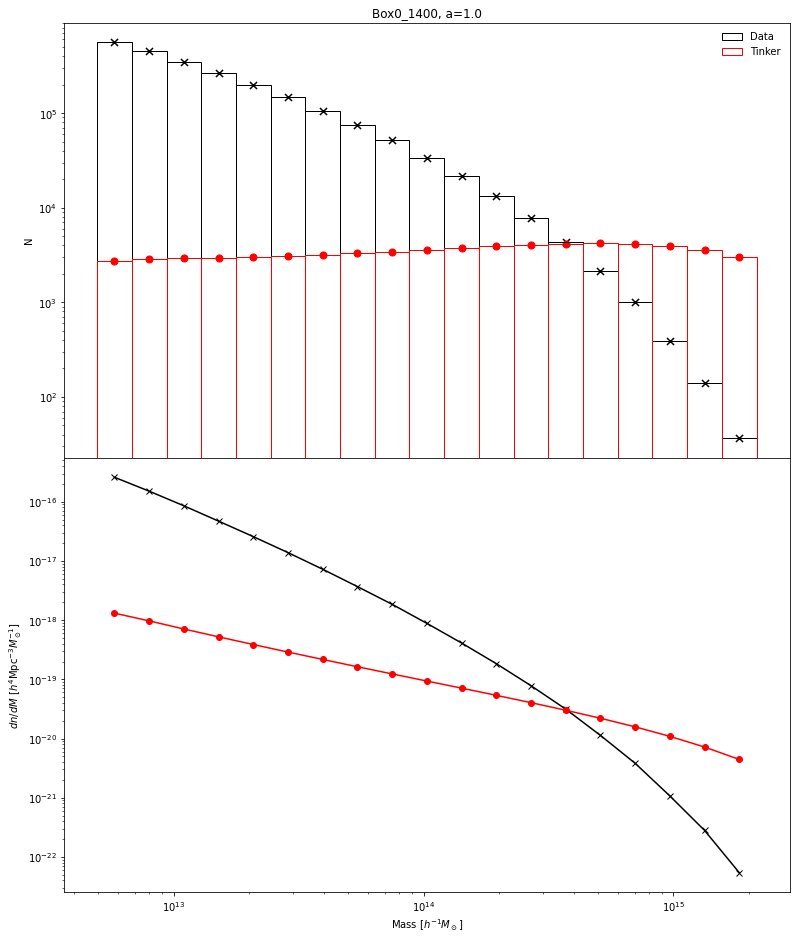

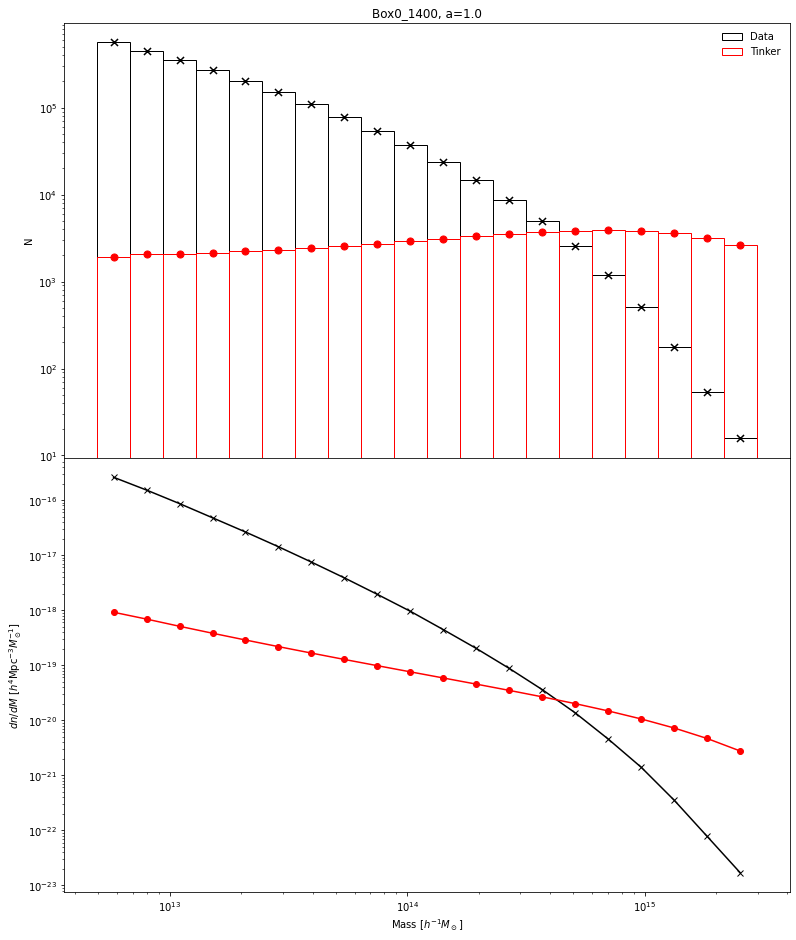

In [105]:
from scipy.interpolate import interp1d
i=0
for z in Pkz.keys():
    a = z_to_a[z]
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,16))
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M']
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    
    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]



    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])
    dndM = (N/vol)/dM

    tinker_eval = [tinker(a, M_c,**params_final,
                          dlnσinvdM=dlnσinvdMs[a], 
                          Pk=Pkz[z],
                          R=M_to_R(M_c, box, a),
                          rhobm=rhom_a(box,a)) for M_c in Ms]

    axs[1].plot(Ms, dndM, 'x-', color='black')
    axs[1].plot(Ms, tinker_eval, 'o-', color='red')



    tinker_eval = [tinker(a, M_c,**params_final,
                          dlnσinvdM=dlnσinvdMs[a], 
                          Pk=Pkz[z],
                          R=M_to_R(M_c, box, a),
                          rhobm=rhom_a(box,a))*vol for M_c in M_numerics]
    
    f_dndM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
    
    tinker_eval = np.array([quad(f_dndM, edge[0],  edge[1])[0] for edge in edge_pairs])

    color = plt.colormaps["rainbow"]((i+1)/len(Pkz.keys()))[:-1]

    
    edge_centers = [np.sqrt(edge[0]*edge[1]) for edge in edge_pairs]
    
    axs[0].scatter(Ms, N, s=50, marker='x', c='black')
    axs[0].scatter(edge_centers, tinker_eval, s=50 , marker='o', c='red')
    
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges), align='edge', fill=False, ec='black', label='Data')
    axs[0].bar(x=edges[:-1], height=tinker_eval, width=np.diff(edges), align='edge', fill=False, ec='red', label='Tinker')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].legend(frameon=False)
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$dn/dM\ [h^4{\rm Mpc}^{-3}M_\odot^{-1}]$')
    axs[0].set_title('%s, a=%.1f'%(box, a))
    i+=1
    plt.savefig('figures/%s_ML+MCMCFits_a%.1f.pdf'%(box, a), bbox_inches='tight')
    plt.show()